# Introducing `freqopttest` 
This notebook will introduce you to `freqopttest`, a Python package for a nonparameteric, interpretable two-sample testing as described in 

    Interpretable Distribution Features with Maximum Testing Power
    Wittawat Jitkrittum, Zoltán Szabó, Kacper Chwialkowski, Arthur Gretton
    arXiv. May, 2016.
    
Before running this notebook, make sure that you having `freqopttest` included in Python's search path. See [here](https://github.com/wittawatj/interpretable-test) for how to do this.

Make sure that the following import statements do not produce any fatal error. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import freqopttest.util as util
import freqopttest.data as data
import freqopttest.kernel as kernel
import freqopttest.tst as tst
import freqopttest.glo as glo
import theano

##  Demo: ME test

A two-sample test proposes a null hypothesis $H_0: P=Q$ agains an alternative hypothesis $H_1: P\neq Q$. 
As an example, we will consider a simple two-dimensional toy example where 

$$
P(x) = \mathcal{N}((0,0), I), \\
Q(x) = \mathcal{N}((m_y,0), I). 
$$

We refer to this problem as the Gaussian mean difference (GMD) problem. If $m_y=0$, then $H_0$ is true. If not, then $H_1$ holds. We first create a `SampleSource` object which represents this problem.

In [2]:
# GMD sample source 
# Full sample size
n = 600
# Consider two dimensions here
dim = 2
seed = 15
# mean shift
my = 1.0
ss = data.SSGaussMeanDiff(dim, my=my)
#ss = data.SSGaussVarDiff(dim)
#ss = data.SSSameGauss(dim)
#ss = data.SSBlobs()

# draw n points from P, and n points from Q. tst_data is an instance of TSTData
tst_data = ss.sample(n, seed=seed)
# split the data into training, and test sets with 50%/50% proportion.
# tr, te are objects of type TSTData
tr, te = tst_data.split_tr_te(tr_proportion=0.5, seed=10)

### Plot the data

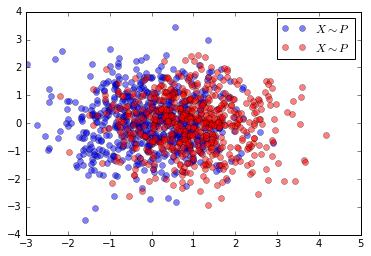

In [3]:
x, y = tst_data.xy()
plt.plot(x[:, 0], x[:, 1], 'bo', label='$X\sim P$', alpha=0.5)
plt.plot(y[:, 0], y[:, 1], 'ro', label='$X\sim P$', alpha=0.5)
plt.legend()

### Optimize the test locations (features) and the Gaussian width
We will use a Gaussian kernel for this test. Let us start by optimizing the parameters (test locations and the Gaussian width) on the training data `tr`.

In [4]:
# J = number of test locations (features)
J = 2
# significance level of the test
alpha = 0.01

In [5]:
op = {'n_test_locs': J, 'seed': seed+5, 'max_iter': 200, 
     'batch_proportion': 1.0, 'locs_step_size': 1.0, 
      'gwidth_step_size': 0.1, 'tol_fun': 1e-4}
# optimize on the training set
test_locs, gwidth, info = tst.MeanEmbeddingTest.optimize_locs_width(tr, alpha, **op)

i:  0, lamb:  42.2, gwidth: 0.375, power: 0.9998
i:  1, lamb:  46.9, gwidth: 0.425, power: 1.0000
i:  2, lamb:  51.8, gwidth: 0.481, power: 1.0000
i:  3, lamb:  56.9, gwidth: 0.545, power: 1.0000
i:  4, lamb:  62.1, gwidth: 0.617, power: 1.0000
i:  5, lamb:  67.1, gwidth: 0.699, power: 1.0000
i:  6, lamb:  71.7, gwidth: 0.792, power: 1.0000
i:  7, lamb:  75.9, gwidth: 0.896, power: 1.0000
i:  8, lamb:  79.5, gwidth:  1.02, power: 1.0000
i:  9, lamb:  82.4, gwidth:  1.15, power: 1.0000
i: 10, lamb:  84.6, gwidth:   1.3, power: 1.0000
i: 11, lamb:  86.1, gwidth:  1.47, power: 1.0000
i: 12, lamb:  87.1, gwidth:  1.67, power: 1.0000
i: 13, lamb:  87.5, gwidth:  1.89, power: 1.0000
i: 14, lamb:  87.6, gwidth:  2.14, power: 1.0000
i: 15, lamb:  87.3, gwidth:  2.43, power: 1.0000
i: 16, lamb:  86.8, gwidth:  2.75, power: 1.0000
i: 17, lamb:    86, gwidth:  3.11, power: 1.0000
i: 18, lamb:  85.2, gwidth:  3.52, power: 1.0000
i: 19, lamb:  84.3, gwidth:  3.99, power: 1.0000
i: 20, lamb:  83.3, 

optimized width: 9.981


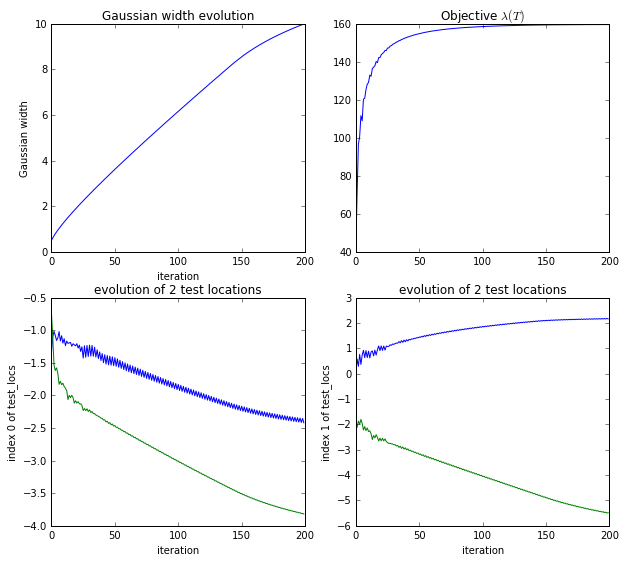

In [6]:
# Plot evolution of the test locations, Gaussian width

# trajectories of the Gaussian width
gwidths = info['gwidths']
fig, axs = plt.subplots(2, 2, figsize=(10, 9))
axs[0, 0].plot(gwidths)
axs[0, 0].set_xlabel('iteration')
axs[0, 0].set_ylabel('Gaussian width')
axs[0, 0].set_title('Gaussian width evolution')

# evolution of objective values
objs = info['obj_values']
axs[0, 1].plot(objs)
axs[0, 1].set_title('Objective $\lambda(T)$')

# trajectories of the test locations
# iters x J. X Coordinates of all test locations
locs = info['test_locs']
for coord in [0, 1]:
    locs_d0 = locs[:, :, coord]
    J = locs_d0.shape[1]
    axs[1, coord].plot(locs_d0)
    axs[1, coord].set_xlabel('iteration')
    axs[1, coord].set_ylabel('index %d of test_locs'%(coord))
    axs[1, coord].set_title('evolution of %d test locations'%J)

print('optimized width: %.3f'%gwidth)

From the optimization, we now have `test_locs` (optimized test locations as a $Jxd$ matrix) and `gwidth` (optimized Gaussian width). Let us use these two parameters to perform the ME test on the test data.

In [7]:
# test with the best optimized test features, and optimized Gaussian width
met_opt = tst.MeanEmbeddingTest(test_locs, gwidth, alpha)
met_opt.perform_test(te)

{'alpha': 0.01,
 'h0_rejected': True,
 'pvalue': 1.9588134215086581e-36,
 'test_stat': 164.44144891011911}

Here we see that the test rejects the null hypothesis with a very small p-value.

**Exercise**: Go back to the beginning, change `my=0`, and run this notebook again. With this setting, we have that $H_0: P=Q$ is true. The test will not reject the null hypothesis.

See `ipynb/me_test.ipynb` for more ways to use the ME test. See `ipynb/smooth_cf_test.ipynb` on how to use the SCF test with optimization.